# [Computational Social Science]
## 3-2 Tree-Based Methods - Student Version

In this lab, we will explore decision trees and their extensions. In the next lab, we will introduce ensemble machine learning, which involves combining several machine learning algorithms together to create a better model.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

## Data

We're going to use our [Census Income dataset](https://archive.ics.uci.edu/dataset/20/census+income) again for this lab. Let's load the dataset.

In [5]:
# import libraries 
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

# settings
%matplotlib inline
#sns.set_style("darkgrid")

In [7]:
# Create a list of column names, found in "adult.names"
col_names = ['age', 
             'workclass', 
             'fnlwgt',
             'education', 
             'education-num',
             'marital-status', 
             'occupation', 
             'relationship', 
             'race', 
             'sex', 
             'capital-gain',
             'capital-loss', 
             'hours-per-week',
             'native-country', 
             'income-bracket']

# Read table from the data folder
census = pd.read_table("../../data/adult.data", 
                       sep = ',', 
                       names = col_names)
census.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Remember, we need to preprocess the data to binarize the target and dummify our categorical features.

In [21]:
# Target
# ----------
# initialize binarizer function and store a binary version of the outcome variable as "y"
lb_style = LabelBinarizer()
y = census['income-bracket-binary'] = lb_style.fit_transform(census['income-bracket'])

# Features 
# ----------
# drop 3 variables: income-bracket, fnlwgt, and income-bracket-binary
X = census.drop(['income-bracket','fnlwgt','income-bracket-binary'], 
                axis = 1)
# get dummies
X = pd.get_dummies(X, dtype = int)
X.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,7,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Decision Tree Classifier

The first model we will look at is the decision tree. Using the [`tree.DecisionTreeClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) method, let's implement a cross-validation approach to predicting income. We will initialize the model with the standard configurations from the Classification lab.

In [25]:
# Initialize a Decision Tree Classifier
# ----------
dt_classifier = tree.DecisionTreeClassifier(
                       criterion='gini',              # or 'entropy' for information gain
                       splitter='best',               # or 'random' for random best split
                       max_depth=None,                # set how deep tree nodes can go
                       min_samples_split=2,           # samples (observations) needed to split node
                       min_samples_leaf=1,            # samples (observations) needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,             # number of features to look for when splitting
                       max_leaf_nodes=None,           # max nodes
                       min_impurity_decrease=1e-07,   # early stopping
                       random_state = 10)             #random seed

In [31]:
# cross_val_score returns the accuracy score by default but you can change this with the "scoring" argument
scores = cross_val_score(dt_classifier,             # specify estimator 
                         X,               # specify X
                         y,               # specify y
                         cv = 5)             # specify 5 cross-validation folds

In [33]:
# view accuracy
print (scores)

[0.82189467 0.82048526 0.81557125 0.82125307 0.82202088]


In [35]:
# Take the mean accuracy score from the results of cross validation
scores.mean()

0.8202450278049079

.82 accuracy, not bad! We can also visualize the decision tree to see how it made its splits. Note we limit the max depth to 4 so that the code runs quickly, but in practice you might want to visualize the entire tree.

In [37]:
# get the shape of the data
X.shape

(32561, 107)

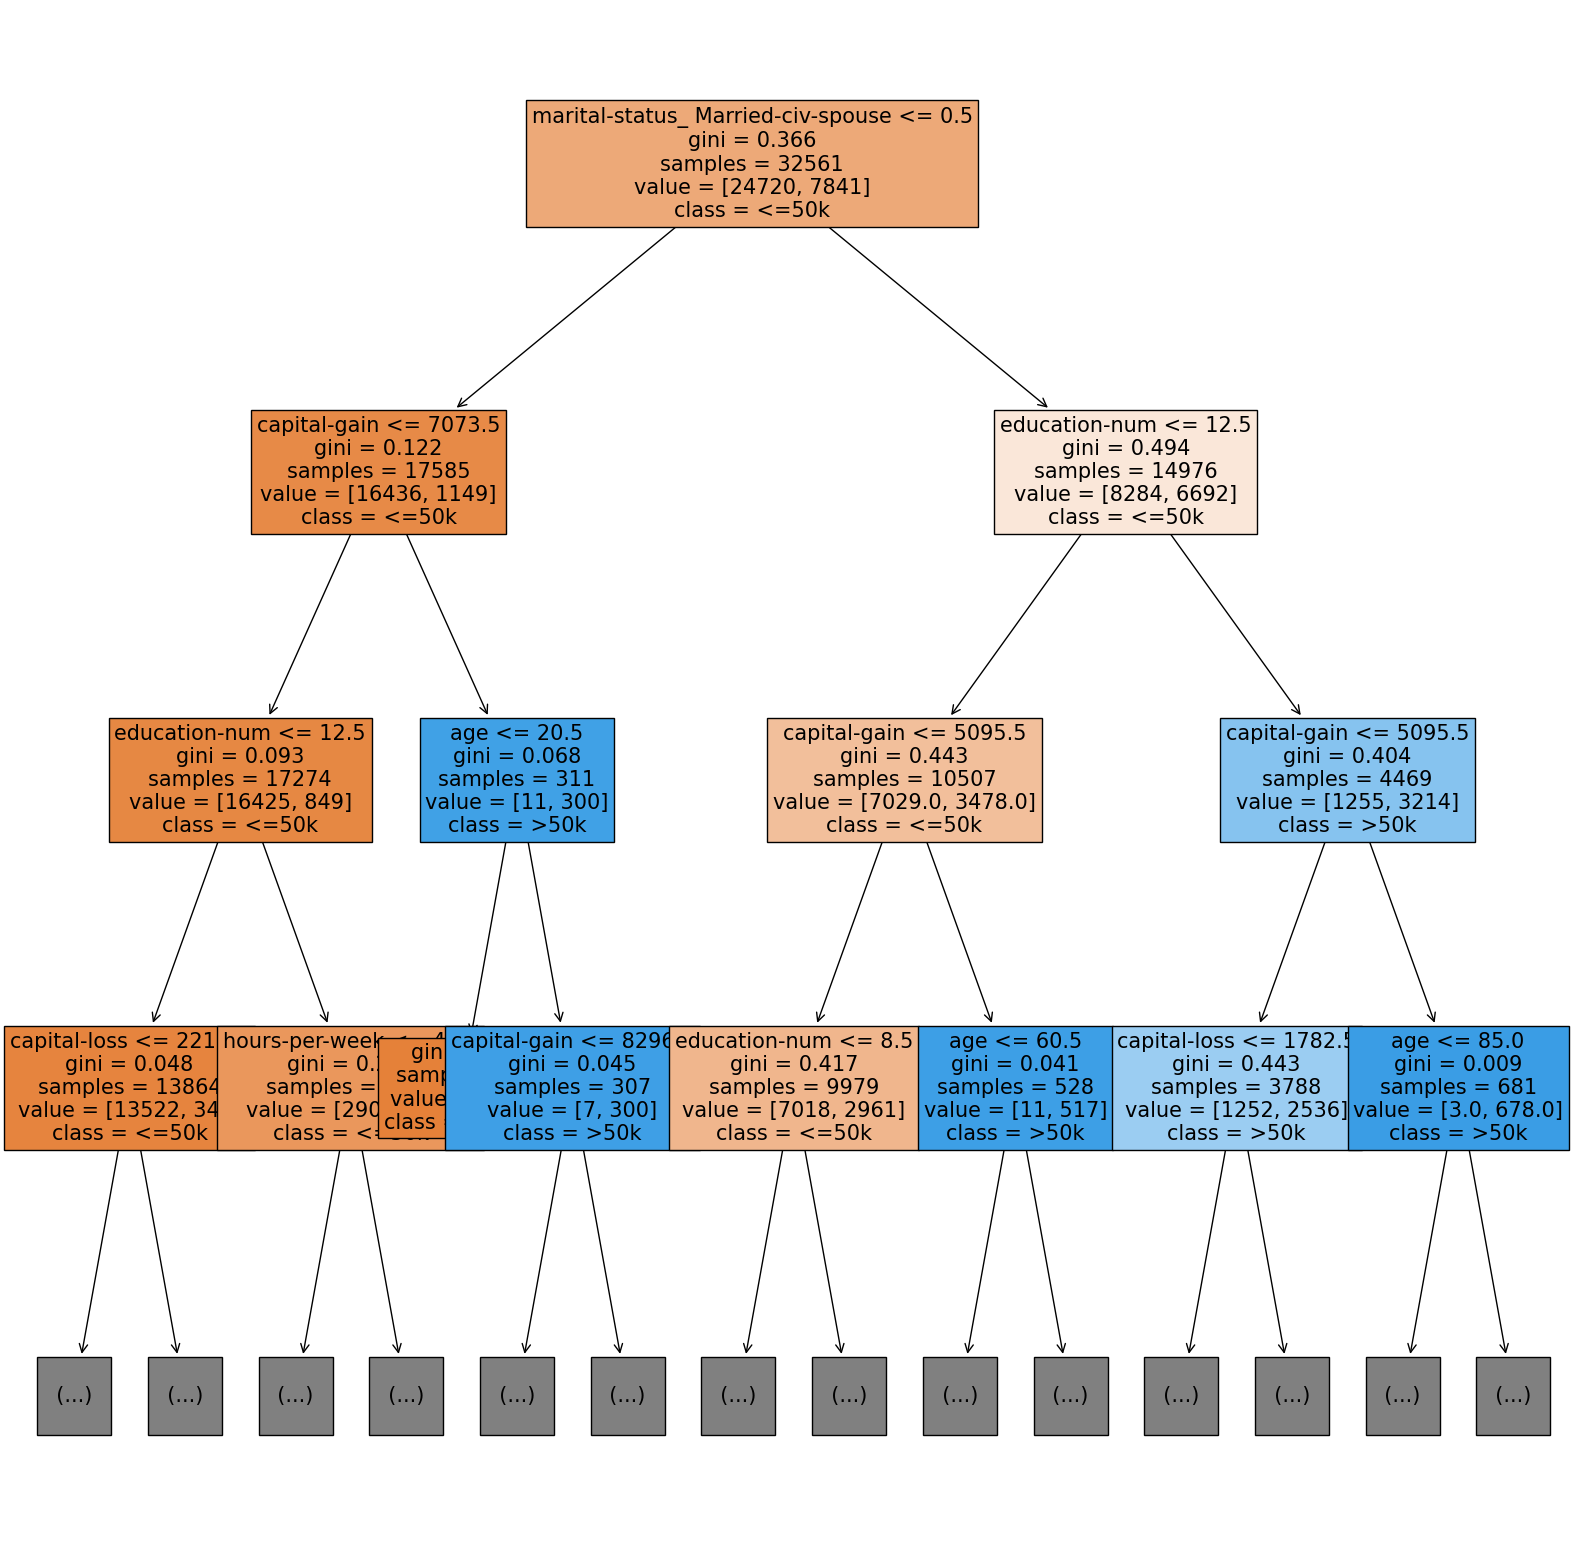

In [39]:
# fit to data
# ----------
dt_classifier.fit(X, y)

# set column names as list
column_names = X.columns.tolist()

# plot the figure
fig = plt.figure(figsize=(20,20))
_ = tree.plot_tree(dt_classifier,  
                   feature_names=column_names,      # make sure its a list
                   class_names=["<=50k", ">50k"],   # specify class names
                   filled=True,                     # paint nodes to indicate majority class 
                   fontsize = 15,                   # set fontsize
                   max_depth = 3)                   # set max depth of tree to view

In [41]:
# We can use the .max_depth attribute to check out the depth of our entire tree
dt_classifier.tree_.max_depth

52

In [43]:
# Remind ourselves how many samples in our negative class
np.count_nonzero(y==0)

24720

In [ ]:
# Check the samples after root node
X['marital-status_ Married-civ-spouse'].value_counts()

In [45]:
# Getting the most informative features
# ----------
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(dt_classifier.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
32,marital-status_ Married-civ-spouse,0.214
0,age,0.161
1,education-num,0.125
2,capital-gain,0.120
4,hours-per-week,0.100
...,...,...
78,native-country_ Guatemala,0.000
79,native-country_ Haiti,0.000
80,native-country_ Holand-Netherlands,0.000
81,native-country_ Honduras,0.000


---
Authored by Aniket Kesari. Minor edits by Tom van Nuenen 2022 and Kasey Zapatka in 2023.